### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import seaborn as sns
import subjects
from neuropy.utils.signal_process import WaveletSg

# sessions = (
#     subjects.sd.ratJday1
#     + subjects.sd.ratKday1
#     + subjects.sd.ratNday1
#     + subjects.sd.ratSday3
#     + subjects.sd.ratRday2
#     + subjects.sd.ratUday4
#     + subjects.sd.ratVday2
#     + subjects.nsd.ratJday2
#     + subjects.nsd.ratKday2
#     + subjects.nsd.ratNday2
#     + subjects.nsd.ratSday2
#     + subjects.nsd.ratRday1
#     + subjects.nsd.ratUday2
#     + subjects.nsd.ratVday1
# )

# rpl_channels = [39, 63, 111, 95, 49, 100, 85, 63, 63, 36, 188, 16, 99, 86]


### Ripple power spectrum comaprison 1st vs 5th vs 8th hour
- To see if ripple lfp timeseries changes PSD during sleep deprivation and compare it to NSD
- Method: Ripple traces are concatenated in their corresponding hour and then a PSD is calculated
- Results: Compared to 1st hour, ripple band in 5th and 8th hour show a little shift towards slower frequencies (maybe the start cutoff for ripple band is only changing)

In [4]:
import scipy.signal as sg
from neuropy.core import Epoch

psd_rpl_df = pd.DataFrame()
norm_psd = lambda p: p / np.sqrt(p)

for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"]
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"]
    # rpl_chan = sess.ripple.metadata["channels"][2]
    if sess.tag == "sd":
        post = post.flatten()
        post_epochs = Epoch.from_array(
            [post[0], post[0] + 5 * 3600], [post[0] + 5 * 3600, post[1]], ["sd", "rs"]
        )
        all_epochs = pre + maze + post_epochs
    else:
        all_epochs = pre + maze + post

    psd = []
    for e in all_epochs.itertuples():
        signal = sess.eegfile.get_signal(rpl_channels[sub], e.start, e.stop)
        rpl_t = sess.ripple.time_slice(e.start, e.stop).as_array()
        rpl_frames = [np.arange(int(e[0] * 1250), int(e[1] * 1250)) for e in rpl_t]
        rpl_frames = np.concatenate(rpl_frames) - int(e.start * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        f, psd = sg.welch(
            signal.traces[0][rpl_frames], fs=1250, nperseg=125, noverlap=62
        )
        psd_rpl_df = psd_rpl_df.append(
            pd.DataFrame(
                {"freq": f, "psd": psd, "Epoch": e.label, "sub": sub, "grp": sess.tag}
            ),
            ignore_index=True,
        )

subjects.GroupData().save(psd_rpl_df, "ripple_psd")


NameError: name 'sessions' is not defined

In [ ]:
# %matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd", "nsd"]):
    df = psd_rpl_df[psd_rpl_df["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="freq",
        y="psd",
        hue="hour",
        ci=None,
        ax=ax,
        legend=None,
    )
    ax.set_yscale("log")
    # ax.set_xscale('log')
    ax.set_xlim([60, 350])
    ax.set_ylim([5, 100])
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Psd")
    # ax.set_xticks([60,100,200,300],['',100,200,''])
    # ax.set_xticks([100,200],rotation=45)

figure.savefig(subjects.figpath_sd / "ripple_psd_various_epochs")


### Ripple power (z-score) compared NSD vs SD

In [6]:
sessions = subjects.ripple_sess()

In [10]:
zsc_df = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    epochs = sess.get_zt_epochs(include_maze=False)

    for e in epochs.itertuples():
        rpl_df = sess.ripple.time_slice(e.start, e.stop).to_dataframe()
        starts = rpl_df.start.values
        zscores = rpl_df.peak_power.values

        zsc_df.append(
            pd.DataFrame(dict(zscore=zscores, zt=e.label, session=sub, grp=sess.tag))
        )

zsc_df = pd.concat(zsc_df, ignore_index=True)
zsc_df= zsc_df[zsc_df.zscore<18]
subjects.GroupData().save(zsc_df, "ripple_zscore")


ripple_zscore saved


In [ ]:
import seaborn as sns
_,ax = plt.subplots()
# df = zsc_df[zsc_df['grp']=='SD']
# sns.boxplot(data=zsc_df,x='t',y='zscore',hue='grp',showfliers=False)
sns.violinplot(data=zsc_df,x='t',y='zscore',hue='grp',split=True)
ax.set_yscale('log')

### Ripple power vs frequency scatter plot

In [11]:
sessions = subjects.ripple_sess()

In [36]:
ripple_df = []
noisy_trace = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    rpl = sess.ripple.to_dataframe()
    indx = rpl.peak_power.values > 25
    noisy_rpls = sess.ripple[indx]

    channels = np.concatenate(sess.probegroup.get_connected_channels()).astype("int")
    chan = sess.ripple.metadata["channels"][3]

    if len(noisy_rpls) > 0:
        noisy_trace.append(
            sess.eegfile.get_frames_within_epochs(sess.ripple, chan).reshape(-1)
        )

    ripple_df.append(
        pd.DataFrame(
            dict(
                freq=rpl.peak_frequency_bp,
                power=rpl.peak_power,
                session=sub,
                grp=sess.tag,
            )
        )
    )

ripple_df = pd.concat(ripple_df, ignore_index=True)
noisy_trace = np.concatenate(noisy_trace)


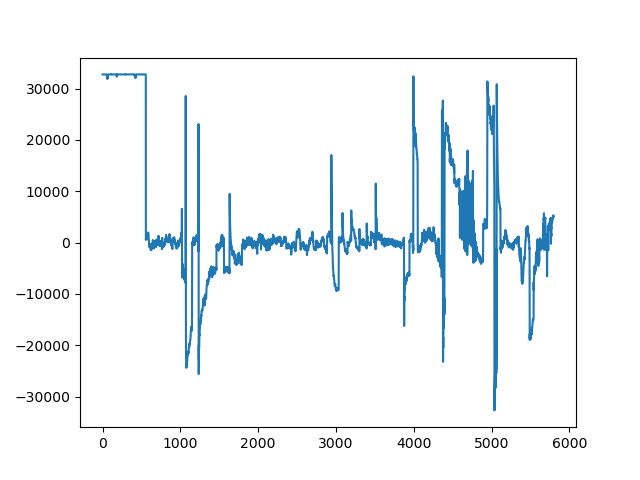

In [35]:
_,ax = plt.subplots()
# sns.scatterplot(data=ripple_df,x='freq',y='power')
ax.plot(noisy_trace)
# ax.set_yscale('log')

### Peri SWR spectrogram at selected ZTs for POST
- Basically average wavelet spectrogram across all ripples
- For SD sessions, I did not find any interesting dynamics other than an additional bump in the 15-30 Hz for Zt1, Zt3 and Zt5. Probably similar to what has been reported in Oliva2018 (Origin of gamma frequency power during hippocampal swrs).
- Did not do this analysis for NSD sessions.

In [ ]:
sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    # subjects.nsd.ratNday2
    # + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    # + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)
rpl_channels = [39, 63, 111, 95, 49, 100, 85, 63, 63, 36, 188, 16, 99, 86]
# rpl_channels=[100]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal

spect = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    # rpl_chan = sess.ripple.metadata["channels"][2]

    t_starts = np.arange(0, 5, 2) * 3600 + post[0]

    freqs = np.geomspace(4, 350, 200)
    for t in t_starts:
        signal = sess.eegfile.get_signal(rpl_channels[sub], t, t + 3601)
        rpl_df = sess.ripple.time_slice(t, t + 3600).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 250, p + 250) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        wvlt = WaveletSg(
            signal=new_sig,
            freqs=freqs,
            ncycles=10,
        )
        # wvlt_mean = np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)).mean(
        #     axis=1
        # )
        wvlt_median = np.median(
            np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)), axis=1
        )
        spect.append(wvlt_median)


In [ ]:
from neuropy.plotting import Fig
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

figure = Fig()
fig, gs = figure.draw(grid=(5, 3))

for i in range(3):
    s = np.dstack(spect[i::3]).mean(axis=-1)
    # s = gaussian_filter(s,sigma=2)
    ax = plt.subplot(gs[i])
    ax.imshow(
        # np.linspace(-200, 200, 500),
        # freqs,
        stats.zscore(s, axis=1),
        # s,
        # extent=[-200,200],
        cmap="jet",
        # shading="gouraud",
        # vmax= 5,
        # norm=LogNorm(),
        interpolation="sinc",
        origin="lower",
        aspect="auto",
    )
    # ax.set_yscale('log')
    ax.set_yticks(np.arange(200)[::30], freqs[::30].round().astype("int"))
    ax.set_xticks([125, 250, 375], [-100, 0, 100])
    # ax.plot(np.median(s,axis=1))
# plt.yscale('log')

figure.savefig(subjects.figpath_sd / "ripple_peri_spectrogram_SD")


### Sharp wave amplitude across sleep

In [ ]:
from joblib import Parallel, delayed

sessions = subjects.ripple_sess()

get_extrema = lambda arr: arr[np.argmax(np.abs(arr))]
def get_max_val(x, t, bins):
    return stats.binned_statistic(t, x, bins=bins, statistic=get_extrema)[0][::2]


sw_amp_df = []
for sub, sess in enumerate(tqdm(sessions)):
    maze = sess.paradigm["maze"].flatten()

    epochs = sess.get_zt_epochs() 
    srate = sess.eegfile.sampling_rate

    # shank_channels = sess.probegroup.get_connected_channels()[shanks[sub]].astype("int")
    # channels = [shank_channels[0], shank_channels[1]]
    good_channels = np.concatenate(sess.probegroup.get_connected_channels()).astype(
        "int"
    )
    # traces = stats.zscore(sess.eegfile.get_signal(channels).traces, axis=1)
    # eeg = sess.eegfile.get_signal(good_channels, *maze).traces
    # mean_eeg = eeg.mean(axis=1)[:, np.newaxis]
    # std_eeg = eeg.std(axis=1)[:, np.newaxis]

    rpl_epochs = sess.ripple.flatten()
    rpl_starts = rpl_epochs[::2]
    rpl_traces, t = sess.eegfile.get_frames_within_epochs(
        sess.ripple, good_channels, ret_time=True
    )

    # rpl_norm_traces = stats.zscore(rpl_traces, axis=1)

    # max_val = []
    # for trace in rpl_traces:
    #     max_val.append(
    #         stats.binned_statistic(t, trace, bins=rpl_epochs, statistic=get_extrema)[0][
    #             ::2
    #         ]
    #     )

    max_val = Parallel(n_jobs=8)(
        delayed(get_max_val)(arr, t, rpl_epochs) for arr in rpl_traces
    )
    max_val = np.asarray(max_val)

    # sw_amp = stats.zscore(np.ptp(max_val, axis=0))
    sw_amp = np.ptp(max_val, axis=0)

    maze_indx = (rpl_starts >= maze[0]) & (rpl_starts < maze[1])
    mean_maze_amp = np.mean(sw_amp[maze_indx])
# 
    for e in epochs.itertuples():
        indx = (rpl_starts >= e.start) & (rpl_starts < e.stop)
        df = pd.DataFrame(
            dict(sw_amp=sw_amp[indx] / mean_maze_amp, zt=e.label, grp=sess.tag)
        )
        sw_amp_df.append(df)

sw_amp_df = pd.concat(sw_amp_df, ignore_index=True)
subjects.GroupData().save(sw_amp_df,'ripple_sw_amp')


  0%|          | 0/16 [00:00<?, ?it/s]

ripple_sw_amp saved


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0-2.5_NSD vs. 0-2.5_SD: Welch's t-test independent samples, P_val:0.000e+00 t=3.875e+01
PRE_NSD vs. PRE_SD: Welch's t-test independent samples, P_val:7.156e-02 t=-1.802e+00
2.5-5_NSD vs. 2.5-5_SD: Welch's t-test independent samples, P_val:2.219e-287 t=3.642e+01
5-7.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:0.000e+00 t=-4.047e+01


/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


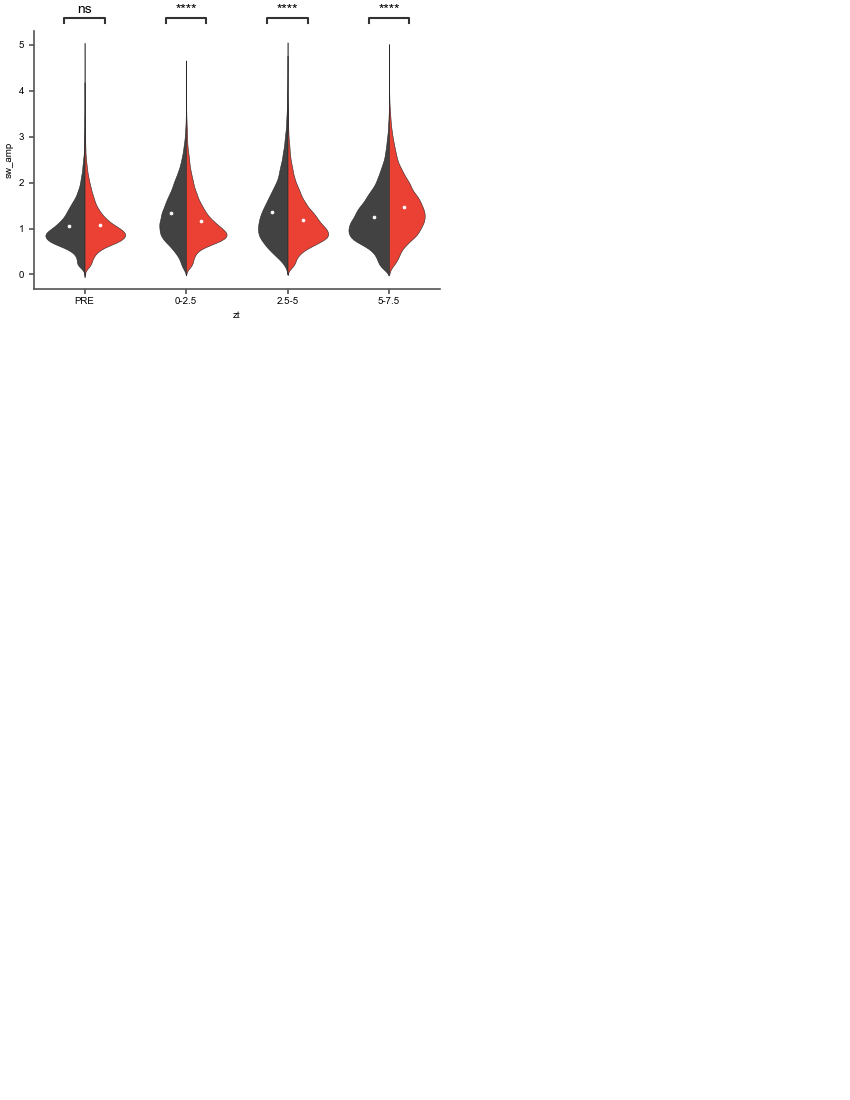

In [ ]:
from plotters import violinplot
from statannotations.Annotator import Annotator
from neuropy import plotting


data = sw_amp_df[(sw_amp_df.sw_amp < 5) & (sw_amp_df.zt != "MAZE")]
# data = sw_amp_df[sw_amp_df.sw_amp < 5]
# data = sw_amp_df
fig = plotting.Fig(grid=(4,2))
ax = fig.subplot(fig.gs[0])
plot_kw = dict(data=data, x="zt", y="sw_amp", hue="grp", hue_order=["NSD", "SD"],ax=ax)

violinplot(**plot_kw)
ax.legend("", frameon=False)
# stats
orders = data.zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
annotator.configure(test="t-test_welch",loc='outside')
annotator.apply_and_annotate()
annotator.reset_configuration()

# fig.savefig(subjects.figpath_sd/'sharp_wave')

### Awake vs Sleep ripples features
- Do awake ripples look different that sleep ripples

In [ ]:
sessions = subjects.sd.ratUday4

In [ ]:
from neuropy.utils.signal_process import hilbertfast, filter_sig
from sklearn.decomposition import PCA



def get_pca(epochs, channels):
    pca_rpls = []
    for e in epochs.as_array():
        signal = sess.eegfile.get_signal(channels, e[0], e[1])
        # amp = np.abs(filter_sig.bandpass(signal.traces, lf=2, hf=25, fs=1250, ax=-1))
        amp = np.abs(signal.traces)


        # pca = PCA(n_components=1).fit_transform(signal.traces)
        # pca_rpls.append(pca.reshape(-1))
        pca_rpls.append(np.max(amp, axis=1))
    return np.array(pca_rpls)


for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    channels = sess.recinfo.channel_groups[6].astype("int")
    maze_rpls = sess.ripple.time_slice(*maze)
    post_rpls = sess.ripple.time_slice(post[0] + 3600, post[0] + 6 * 3600)

    maze_pca = get_pca(maze_rpls, channels)
    post_pca = get_pca(post_rpls, channels)


In [ ]:
from scipy.ndimage import gaussian_filter1d
_,ax = plt.subplots()

vals = np.concatenate([maze_pca[:,0],post_pca[:,0]])
ax.plot(gaussian_filter1d(vals,2))

In [ ]:
plt.clf()
_,ax = plt.subplots()

colors = ['r','k']
for i,p in enumerate([maze_pca,post_pca]):
    ax.scatter(p[:,0],p[:,15],c=colors[i],s=5,alpha=0.2)

In [ ]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from neuropy.core import Epoch
from sklearn.neighbors import LocalOutlierFactor


pca_of_rpl_amp = PCA(n_components=2).fit_transform(pca_ripples)
features = MinMaxScaler().fit_transform(pca_of_rpl_amp) 
labels = GaussianMixture(n_components=2,random_state=0).fit_predict(features)
outliers= LocalOutlierFactor(n_neighbors=20).fit_predict(features)

# starts,stops = sess.ripple.starts,sess.ripple.stops
# weird_ripples = Epoch.from_array(starts[labels==0],stops[labels==0])
# sess.recinfo.write_epochs(weird_ripples,ext='wrp')


In [ ]:
%matplotlib widget

for l in [0,1]:
    plt.plot(features[labels==l,0],features[labels==l,1],'.')

plt.plot(features[outliers==-1,0],features[outliers==-1,1],'k.')

### Ripple direction

In [ ]:
sessions = subjects.nsd.ratUday2

In [ ]:
0.012/(1/1250)

In [ ]:
from neuropy.utils.signal_process import hilbertfast,filter_sig
from scipy.ndimage import gaussian_filter1d

rng = np.random.default_rng()
smooth = lambda arr: gaussian_filter1d(arr,sigma=0.012*1250,axis=-1)
for sub,sess in enumerate(sessions):
    maze = sess.paradigm['maze'].flatten()
    channels = sess.ripple.metadata['channels']
    rpls = sess.ripple.time_slice(*maze).to_dataframe().peak_time.values

    indx = rng.choice(len(rpls))
    t = rpls[indx] 
    ep = [t-0.5,t+0.5]
    signal = sess.eegfile.get_signal(channels,*ep)
    rpl_band = filter_sig.bandpass(signal,lf=125,hf=250)
    hil_amp = np.abs(hilbertfast(rpl_band.traces,ax=-1))
    hil_amp = smooth(hil_amp)
    
    

In [ ]:
from matplotlib.cm import get_cmap
_,ax = plt.subplots()

a = hil_amp + np.linspace(0,600,len(channels))[::-1][:,np.newaxis]

cmap = get_cmap('Reds')

for i in range(len(channels)):
    ax.plot(a[i],color=cmap(i/len(channels)+0.05))